<a href="https://colab.research.google.com/github/MHamiid/IMDB_Movie_Review_Classifier/blob/master/IMDB_Movie_Review_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import csv
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

Setting up *kaggle.json*

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json #json file needed to use kaggle api.

api_token = {"username":"YourUserName","key":"ApiKey"} #use your own kaggle username and api key.

with open("/root/.kaggle/kaggle.json" , "w") as file:
    json.dump(api_token , file)

!chmod 600 ~/.kaggle/kaggle.json    

Download IMDB Dataset

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 35% 9.00M/25.7M [00:00<00:01, 15.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 40.5MB/s]


Unzip dataset

In [4]:
!mkdir /content/dataset
!unzip imdb-dataset-of-50k-movie-reviews.zip -d /content/dataset

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: /content/dataset/IMDB Dataset.csv  


**Helper functions**

In [5]:
def get_csv_data(file_name , stop_words):
  sentences = []
  original = []
  labels = []
  with open(file_name , "r") as file:
    reader = csv.reader(file , delimiter = ",")
    next(reader) #skip csv header.
    for row in reader:
      labels.append(row[1])
      sentence = row[0]
      sentence = sentence.replace("<br /><br />" , " ") #remove the end-line tag that appears in all examples.
      original.append(row[0])
      #remove stop words and extra spaces.
      if stop_words is not None:
        for stopWord in stop_words:
            sentence = sentence.replace(" "+stopWord +" " , " ")
            sentence = sentence.replace(" "+stopWord.title() +" " , " ")
            sentence = sentence.replace("  " , " ")
      sentences.append(sentence)
  return sentences , labels , original     


def inverse_dictionary(dict):
  return {value: key for key, value in dict.items()}


def decode_sequence(sequence , dict):
    return ' '.join([dict.get(i, '?') for i in sequence])

    

Process CSV file


In [6]:
#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
# stop_words = [ "br" ,"a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
sentences , labels , original = get_csv_data("/content/dataset/IMDB Dataset.csv" , None)

In [ ]:
index = 33
print("Sentence length:" , len(sentences[index]))
print(sentences[index])

print("Original length:",len(original[index]))
print(original[index])

In [8]:
print("#Sentences:" , len(sentences))

#Sentences: 50000


 Sentence Tokenizer


In [9]:
vocab_size = 30000
max_length = 300
padding_dir = "post"
truncating_dir = "post"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size , oov_token = "<OOV>") #will use vocab_size of the total words.
tokenizer.fit_on_texts(sentences)
print("#Total Words:" ,len(tokenizer.word_index) )
print(tokenizer.word_index)
word_index_inverse = inverse_dictionary(tokenizer.word_index) #inversing word_index.

In [11]:
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences , maxlen=max_length , padding=padding_dir , truncating=truncating_dir)

Label Tokenizer

In [12]:
#Using tokenizer for labels to change from string {positive','negative} notation to int notation.
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
#Change the values to binary classes.
label_tokenizer.word_index["positive"]  = 1
label_tokenizer.word_index["negative"]  = 0
label_index_inverse = inverse_dictionary(label_tokenizer.word_index) #inversing word_index.
print("Labels:",label_tokenizer.word_index)

labels_binary = label_tokenizer.texts_to_sequences(labels)

Labels: {'positive': 1, 'negative': 0}


In [13]:

print("Before label tokenization:", labels[0:10])
print("After label tokenization:",labels_binary[0:10])

Before label tokenization: ['positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive']
After label tokenization: [[1], [1], [1], [0], [1], [1], [1], [0], [0], [1]]


Shuffling all the data

In [15]:
#zip each example with its labels.
zipped_dataset = list(zip(padded_sequences , labels_binary))
random.shuffle(zipped_dataset) #shuffle the data randomly.
padded_sequences , labels_binary = zip(*zipped_dataset) #unzip the data.
#print first example after shuffling
print((labels_binary[0],decode_sequence(labels_binary[0] ,label_index_inverse ) ,decode_sequence(padded_sequences[0] , word_index_inverse)))


([1], 'positive', "when the net was first being advertised the ads made it look ridiculous then when i saw it it was actually quite good angela bennett sandra bullock spends her days working on the computer and has never gotten to know her neighbors then through a series of events her identity gets erased by a cabal of shadowy people and she can't prove that she exists some parts of the movie are a little bit far fetched you'd probably know which parts if you saw the movie still it's a good look into what the existence of the internet may have wrought on unsuspecting people i do recommend it ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?")


Spliting data into *training* and *validation*

In [16]:
split_ratio = 0.9
spliting_point = int(len(padded_sequences)*split_ratio)
train_sequences = padded_sequences[:spliting_point]
train_labels = labels_binary[:spliting_point]
valid_sequences = padded_sequences[spliting_point:]
valid_labels = labels_binary[spliting_point:]
print("#Training Examples:" , len(train_sequences))
print("#Validation Examples:" , len(valid_sequences))

#Training Examples: 45000
#Validation Examples: 5000


In [ ]:
print("Showing the first 5 training examples")
for example in range(5):
  print((labels_binary[example],decode_sequence(labels_binary[example] ,label_index_inverse ) ,decode_sequence(padded_sequences[example] , word_index_inverse)))


***Embedding Matrix***

Download pre-trained word embeddings

In [18]:
!kaggle datasets download -d thanakomsn/glove6b300dtxt
!mkdir /content/pre-trained-embedding
!unzip glove6b300dtxt.zip -d /content/pre-trained-embedding

 99% 384M/386M [00:05<00:00, 78.0MB/s]
100% 386M/386M [00:05<00:00, 70.7MB/s]
Archive:  glove6b300dtxt.zip
  inflating: /content/pre-trained-embedding/glove.6B.300d.txt  


In [19]:
#load the whole pre-trained embeddings into list
pre_trained_embedding = {}

with open("/content/pre-trained-embedding/glove.6B.300d.txt") as file:
  for line in file:
    line_list = line.split();
    word = line_list[0] #get the word.
    vector = np.asarray(line_list[1:] ,dtype="float32")#get the embeddings representing that word.
    pre_trained_embedding[word] = vector


print("#pre-trained word embeddings:",len(pre_trained_embedding))

#pre-trained word embeddings: 400000


Creating embedding matrix from pre-trained embeddings

In [20]:
embedding_dimension = 300 #number of dimensions to represent the word.
embedding_matrix = np.zeros((vocab_size+1 , embedding_dimension)) #initialize with zeros, (Adding one to vocab_size for the <OOV> token).
numberOfEmbeddingsCopied = 0
for word , index in tokenizer.word_index.items():
  if index == vocab_size+1:
    break
  embedding_vector = pre_trained_embedding.get(word)
  if embedding_vector is not None:
      numberOfEmbeddingsCopied = numberOfEmbeddingsCopied +1
      embedding_matrix[index] = embedding_vector

print("Copied {} word embeddings".format(numberOfEmbeddingsCopied))    
print("Embedding matrix size:",len(embedding_matrix))

Copied 28020 word embeddings
Embedding matrix size: 30001


In [20]:
#explore dffrent word's embedding values.
index = 2
# print((word_index_inverse.get(index),embedding_matrix[index]))

# Building the model

In [28]:
model = tf.keras.Sequential([
    Embedding(vocab_size+1 , embedding_dimension , input_length=max_length ,weights = [embedding_matrix] , trainable = False),
    Dropout(0.4),
    Conv1D(64 , 5 , activation="relu") ,
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(1 , activation="sigmoid")
])
model.compile(loss = 'binary_crossentropy'  , optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 300)          9000300   
_________________________________________________________________
dropout_9 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,121,261
Trainable params: 120,961
Non-trainable params: 9,000,300
______________________________________

 **Training the model**

In [29]:
history = model.fit(np.array(train_sequences), np.array(train_labels), epochs=10, validation_data=(np.array(valid_sequences), np.array(valid_labels)), verbose=1)

Epoch 1/10
1407/1407 [==============================] - 154s 109ms/step - loss: 0.4850 - accuracy: 0.7643 - val_loss: 0.3638 - val_accuracy: 0.8476
Epoch 2/10
1407/1407 [==============================] - 154s 109ms/step - loss: 0.3498 - accuracy: 0.8501 - val_loss: 0.3073 - val_accuracy: 0.8720
Epoch 3/10
1407/1407 [==============================] - 153s 109ms/step - loss: 0.3128 - accuracy: 0.8699 - val_loss: 0.3045 - val_accuracy: 0.8760
Epoch 4/10
1407/1407 [==============================] - 153s 109ms/step - loss: 0.2904 - accuracy: 0.8794 - val_loss: 0.3342 - val_accuracy: 0.8652
Epoch 5/10
1407/1407 [==============================] - 153s 109ms/step - loss: 0.2683 - accuracy: 0.8890 - val_loss: 0.2611 - val_accuracy: 0.8918
Epoch 6/10
1407/1407 [==============================] - 153s 108ms/step - loss: 0.2549 - accuracy: 0.8971 - val_loss: 0.2657 - val_accuracy: 0.8934
Epoch 7/10
1407/1407 [==============================] - 153s 109ms/step - loss: 0.2410 - accuracy: 0.9029 - val_

<Figure size 432x288 with 0 Axes>

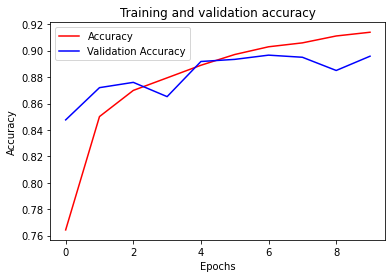

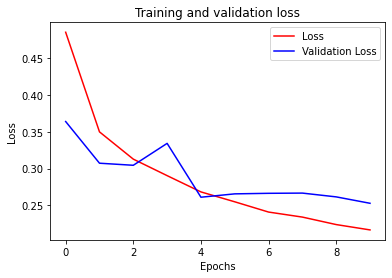

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()



In [68]:
test_cases = ["the acting is not that good" , "this is the most iconic action leading man in history"]
test_sequences = tokenizer.texts_to_sequences(test_cases)
test_padded =pad_sequences(test_sequences , maxlen=max_length , padding=padding_dir , truncating=truncating_dir)
predictions = model.predict(np.expand_dims(test_padded,axis = -1))
for review in range (len(test_cases)):
  if predictions[review]>=0.5:
    print("({})Positive Review:".format(predictions[review]),test_cases[review])
  else:
    print("({})Negative Review:".format(predictions[review]),test_cases[review])



([0.47154722])Negative Review: the acting is not that good
([0.94010925])Positive Review: this is the most iconic action leading man in history


In [69]:
model.save("IMDB_Movie_Review_Classifier.h5")